In [1]:
import numpy as np
import os
import json
import IPython.display as display
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
data_dirs = [d for d in os.listdir('dreamhouse_data/')]

paths = []
costs = []
years = []
beds = []
baths = []
for dd in data_dirs:
    houses_found = [d for d in os.listdir('dreamhouse_data/'+dd) if os.path.isdir('dreamhouse_data/{}/{}'.format(dd,d))]
    with open('dreamhouse_data/{}/metadata.json'.format(dd)) as test_md:
        md = json.load(test_md)
    for house in houses_found:
        house_content = os.listdir('dreamhouse_data/{}/{}'.format(dd,house))
        if 'gsv_0.jpg' in house_content:
            try:
                costs.append(md[house]['PRICE']/100000.)
                years.append(md[house]['YEAR BUILT'])
                beds.append(md[house]['BEDS'])
                baths.append(md[house]['BATHS'])
                paths.append('dreamhouse_data/{}/{}/gsv_0.jpg'.format(dd,house))
            except KeyError:
                print(house,dd)
print(len(paths))
print(len(costs))

00046 data_20176
00048 data_20176
00047 data_20176
00049 data_20176
00045 data_20176
1928
1928


In [59]:
IM_SIZE = 224

In [60]:
def load_and_preprocess(path):
    im = tf.io.read_file(path)
    im = tf.image.decode_jpeg(im,channels=3)
    im = tf.image.resize(im,[IM_SIZE,IM_SIZE])
    #im /= 255.0
    im = tf.cast(im,tf.float32)
    im = (im/127.5)-1
    return im

In [61]:
BUFFER_SIZE = 100
BATCH_SIZE = 64

In [62]:
path_ds = tf.data.Dataset.from_tensor_slices(paths)
image_ds = path_ds.map(load_and_preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [63]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(8, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 112, 112, 8)

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IM_SIZE, IM_SIZE, 3)

    return model

In [64]:
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_10 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 128)        

In [65]:
noise = tf.random.normal([1,100])

generated_image = generator(noise, training=False)

(1, 224, 224, 3)


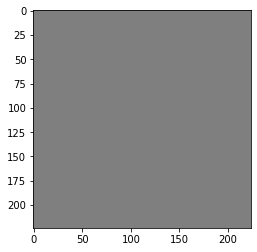

In [67]:
print(generated_image.shape)
plt.imshow(generated_image[0,:,:,:]*0.5+0.5)

In [68]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IM_SIZE, IM_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [69]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 112, 112, 64)      4864      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 128)       204928    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 401408)           

In [70]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00032469]], shape=(1, 1), dtype=float32)


In [71]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [72]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [73]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [74]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [75]:
!mkdir gan_ckpts

mkdir: cannot create directory ‘gan_ckpts’: File exists


In [76]:
checkpoint_dir = 'gan_ckpts'
checkpoint_pref = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

In [77]:
EPOCHS=100
noise_dim=100
num_examples_to_generate=9
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [78]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

In [79]:
def train(dataset,epochs):
    for epoch in range(epochs):
        
        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
        if (epoch+1)%5 == 0:
            checkpoint.save(file_prefix=checkpoint_pref)
            
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

In [88]:
!mkdir gan_frames

In [89]:
def generate_and_save_images(model,epoch,test_input):
    pred = model(test_input,training=False)
    
    fig = plt.figure(figsize=(3,3))
    
    for i in range(pred.shape[0]):
        plt.subplot(3,3,i+1)
        plt.imshow(pred[i,:,:,:]*0.5+0.5)
        plt.axis('off')
        
    plt.savefig('gan_frames/im_at_epoch{:04d}.png'.format(epoch))
    plt.show()

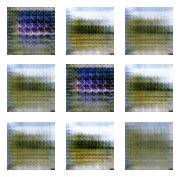

In [90]:
train(image_ds,EPOCHS)

In [84]:
!pip3 install -q imageio

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [86]:
import imageio
import glob

In [93]:
g_file = f'gan_{EPOCHS}.gif'

with imageio.get_writer(g_file,mode='I') as writer:
    fnames = glob.glob('gan_frames/*.png')
    fnames = sorted(fnames)
    for f in fnames:
        im = imageio.imread(f)
        writer.append_data(im)
    image = imageio.imread(f)
    writer.append_data(image)

In [95]:
!pip3 install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.



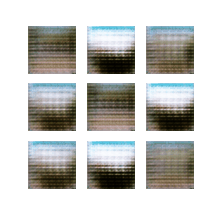

In [96]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(g_file)